# Average cases at and after a policy implementation

In this notebook, we investigate if there is an observable correlation between the implementation of some policy and the change in cases / deaths 14 days afterwards.

To do this, we look at every policy in the policy dataset, find all cases of the policy being implemented at the state or county level, and then measure the difference in cases or deaths from the day the policy was implemented and the 'measure day'. 

# 0. Imports

In [1]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
from covid_project import data_utils as du
from covid_project import deltas_processing as deltas
from covid_project.plotting_funcs import plot_delta_stats
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt

In [2]:
case_data = du.clean_covid_data()
policy_data = du.clean_policy_data()

# 1. Investigate correlations after 14 days

In [3]:
correlated_df, state_cases_dict = deltas.calculate_deltas(
    case_df = case_data,
    policy_df = policy_data,
    measure_period = 14,
)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [4]:
correlated_df.head()

,state,policy_level,date,policy_type,start_stop,county,fips_code,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
1,Mississippi,county,2020-07-20,outdoor and recreation,stop,sunflower,28133,-21.521182,0.075381,2.676014,0.078073
3,Missouri,state,2020-06-15,non-essential businesses,stop,statewide,29,3.646346,0.028410,-0.422237,-0.002055
5,Georgia,county,2020-04-30,childcare (k-12),stop,fulton,13121,-0.111557,0.025932,-0.097857,0.000070
6,Missouri,county,2020-05-31,entertainment,stop,jackson,29095,0.199421,0.071428,0.020231,0.000000
7,Missouri,state,2021-08-31,mask requirement,stop,statewide,29,5.809236,0.268704,0.859299,-0.069659


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # lots of numpy warnings for mean of empty slice

    delta_stats, raws = deltas.calc_delta_stats(correlated_df, measure_period=14)

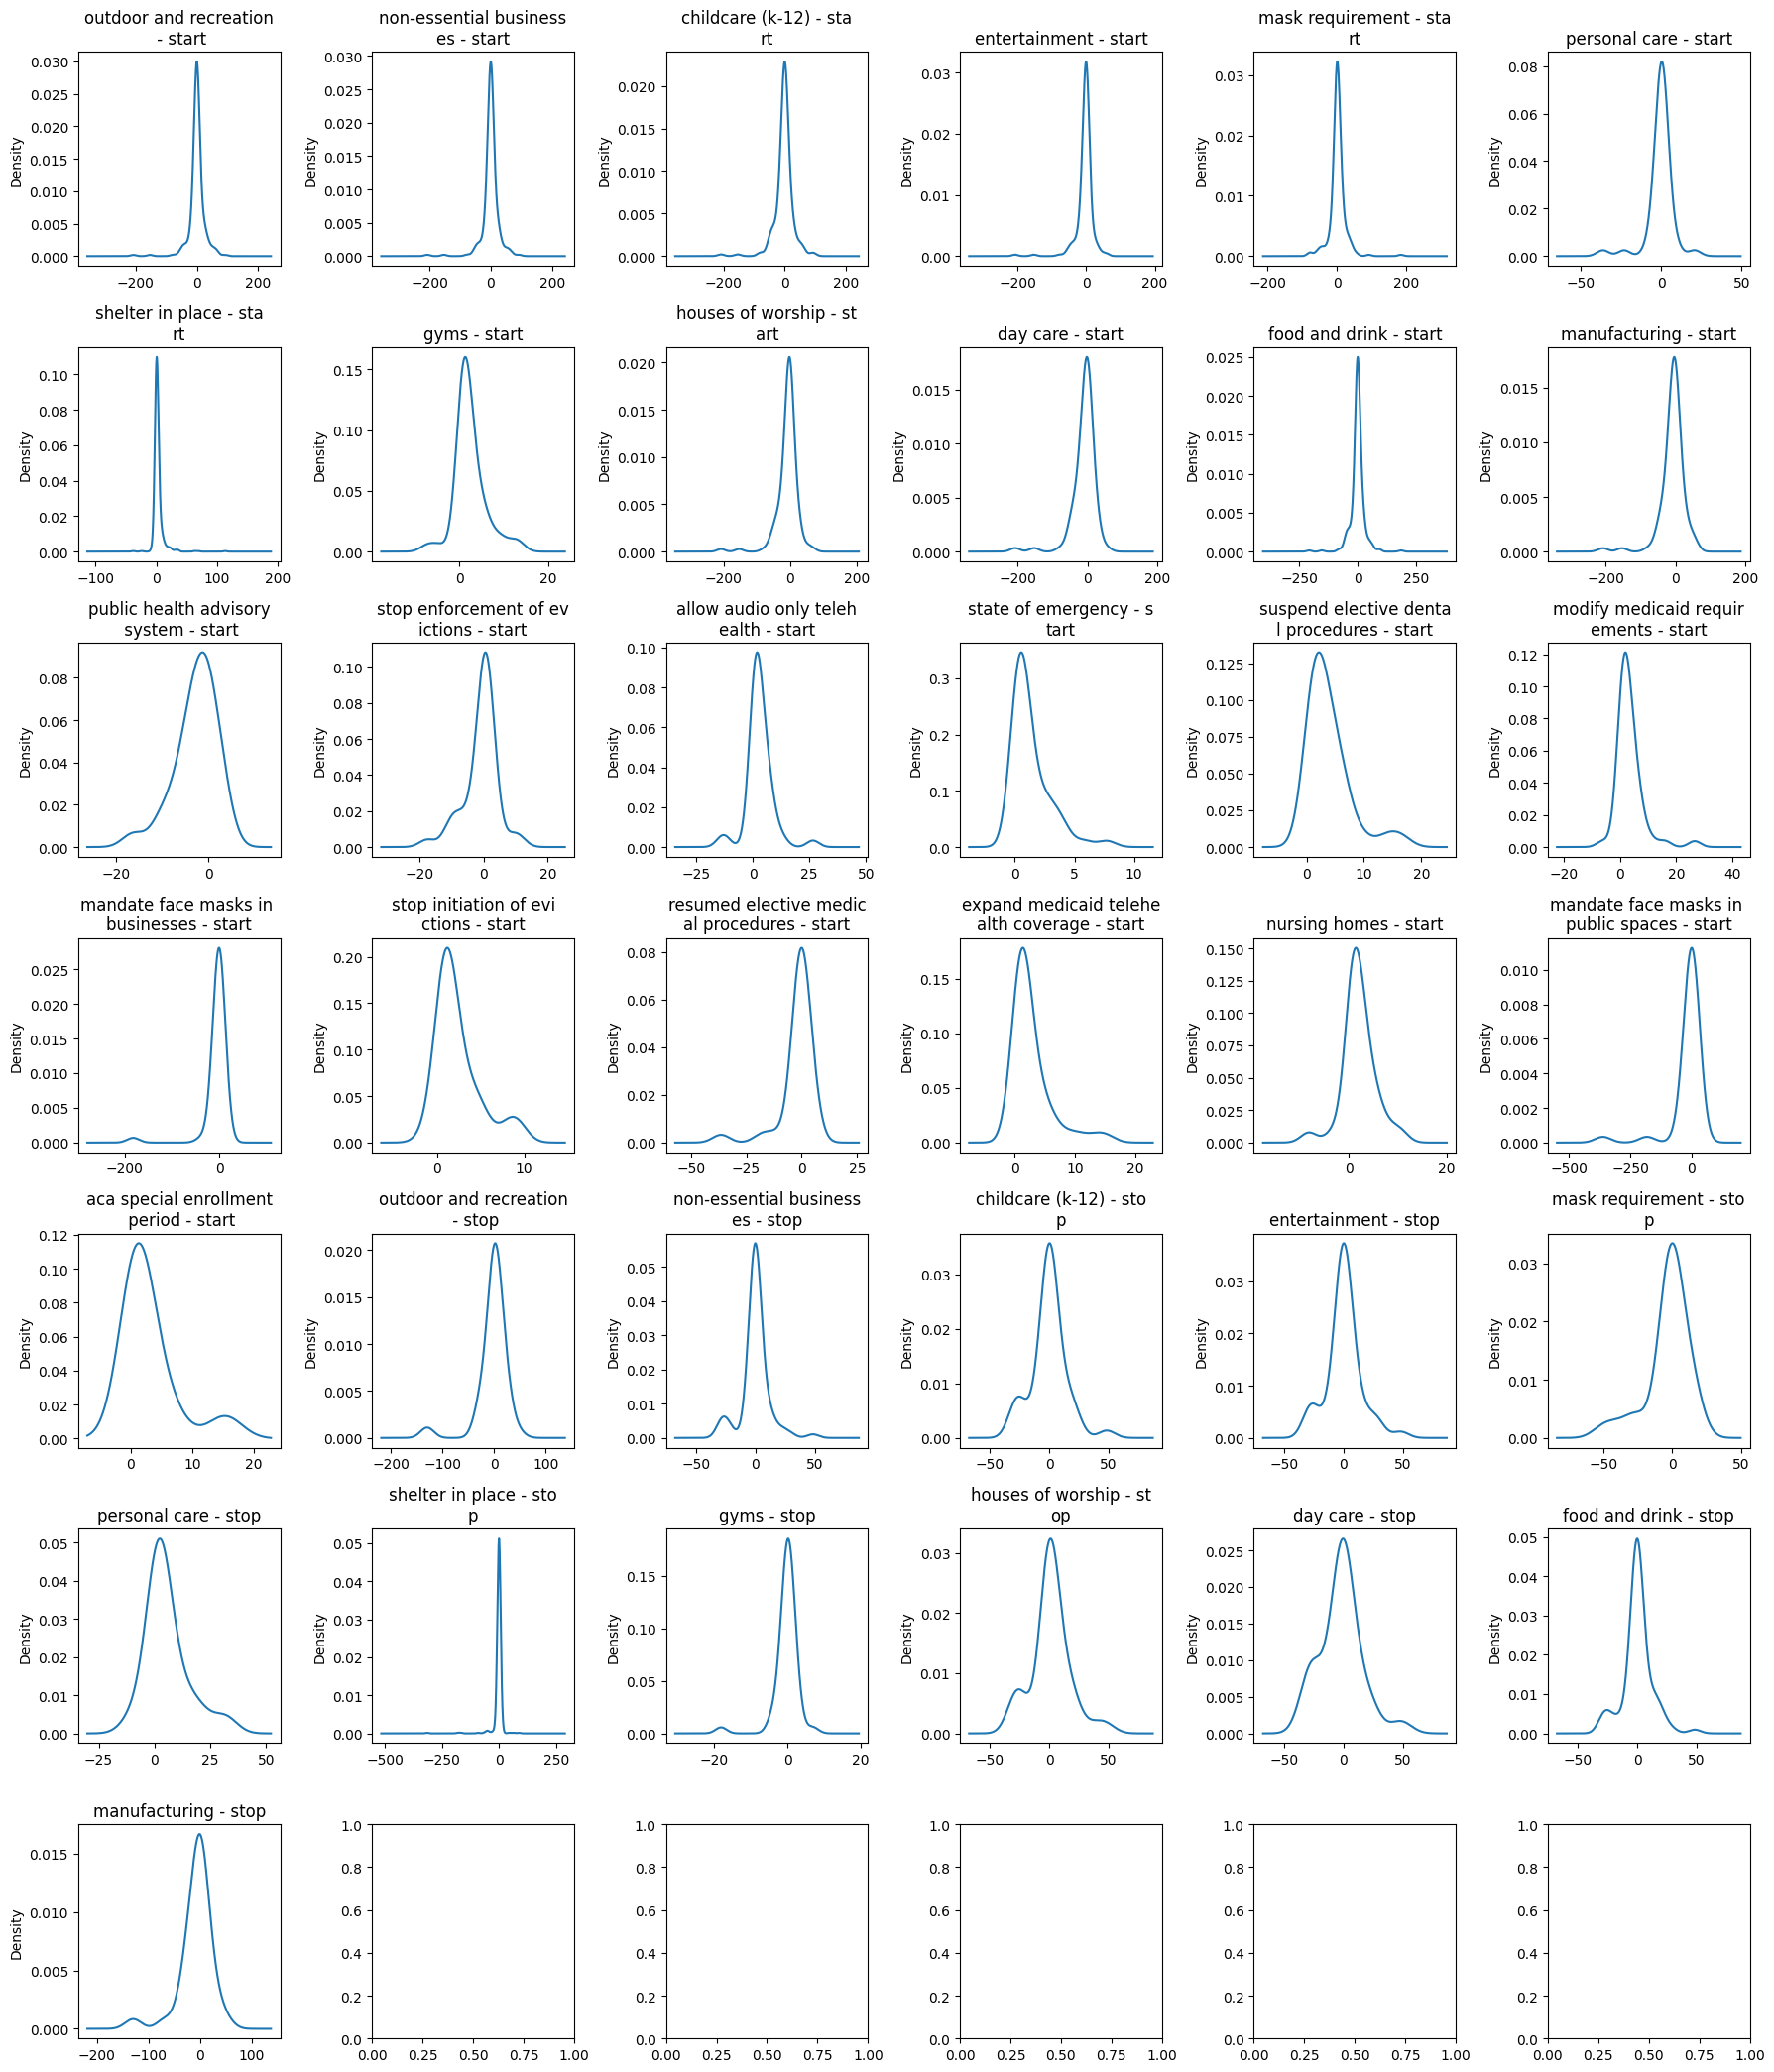

In [6]:
ncols = 6
nrows = (len(raws) // ncols) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=[ncols*3, nrows*3])
axes = axes.flatten()
for i, policy in enumerate(list(raws.keys())):
    raws[policy]['cases'].plot.kde(ax = axes[i])
    if len(policy) > 22:
        policy = policy[:22] + '\n' + policy[22:]
    axes[i].set_title(policy)
fig.tight_layout()

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/plotting_funcs.py:444: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = delta_stats.loc[index][8]


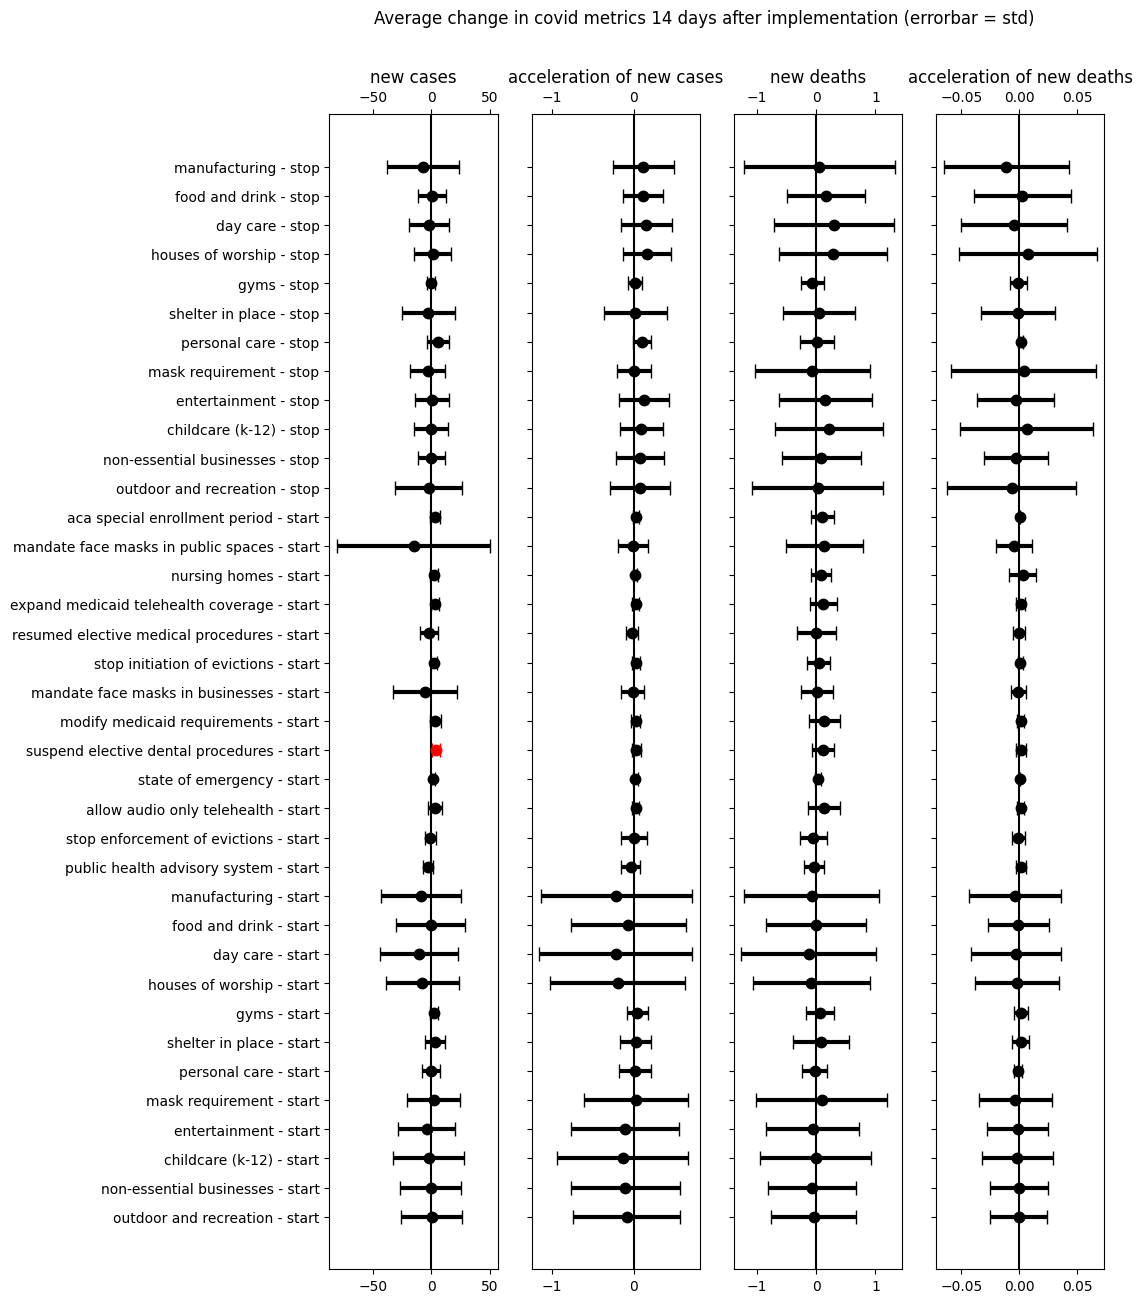

In [7]:
plot_delta_stats(delta_stats,
                 save_figure=True,
                 filename="./figures/average_changes_in_covid_metrics_14_days.png");

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/plotting_funcs.py:444: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = delta_stats.loc[index][8]


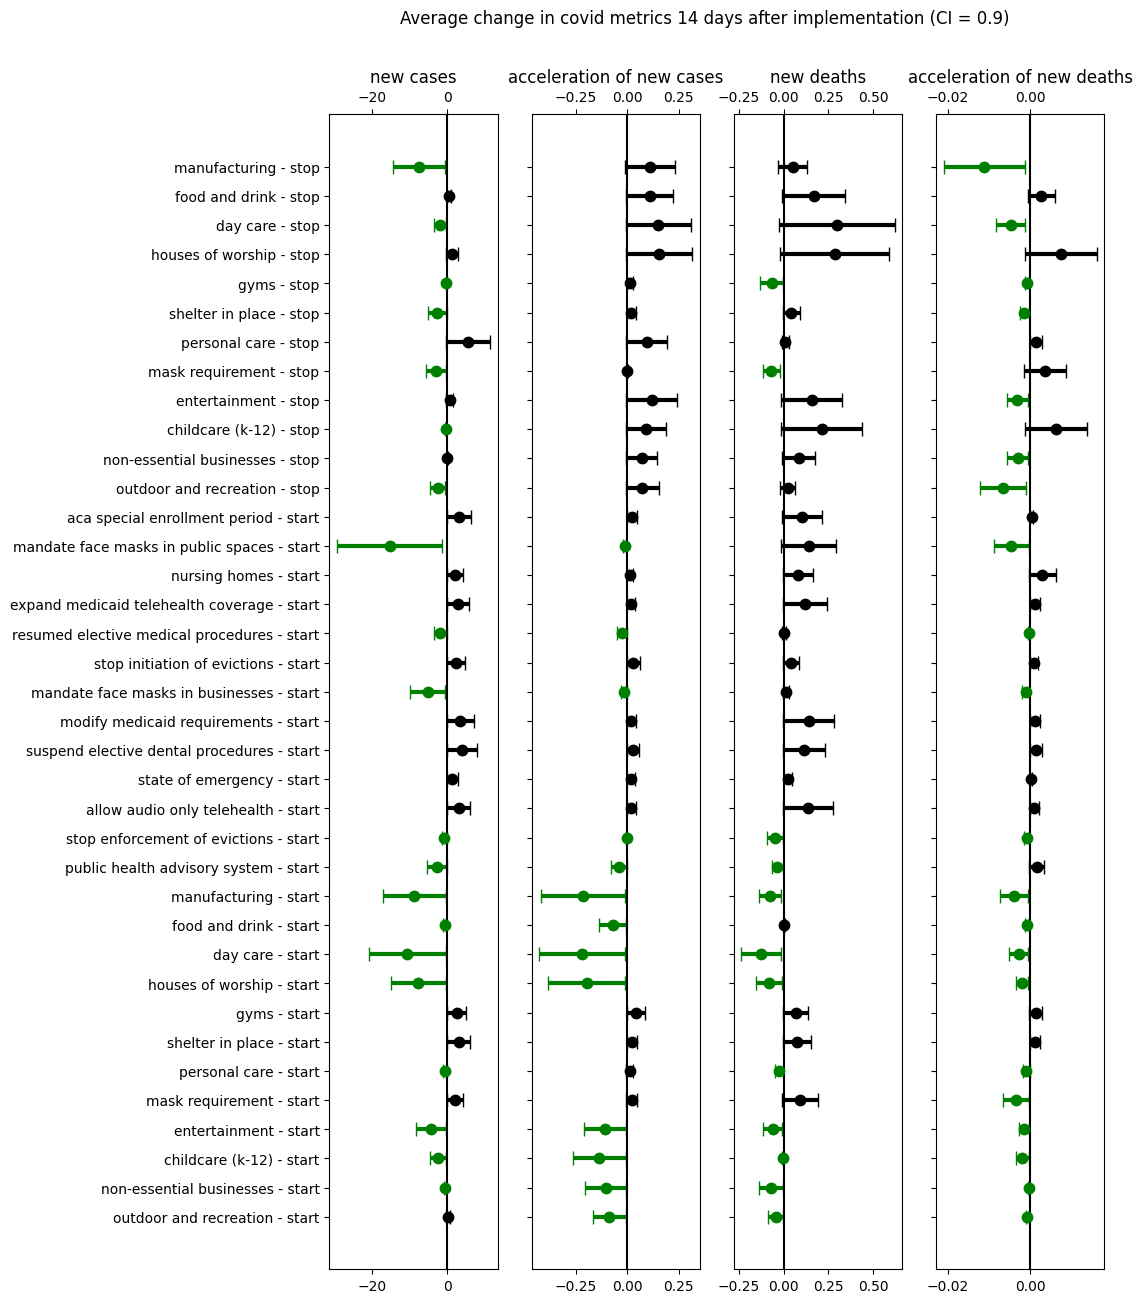

In [8]:
fig = plot_delta_stats(delta_stats,
                 save_figure=True,
                 interval="0.9",
                 filename="./figures/average_changes_in_covid_metrics_14_days_90CI.png");

In [9]:
delta_stats.to_csv("./delta_stats.csv")

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/plotting_funcs.py:444: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = delta_stats.loc[index][8]


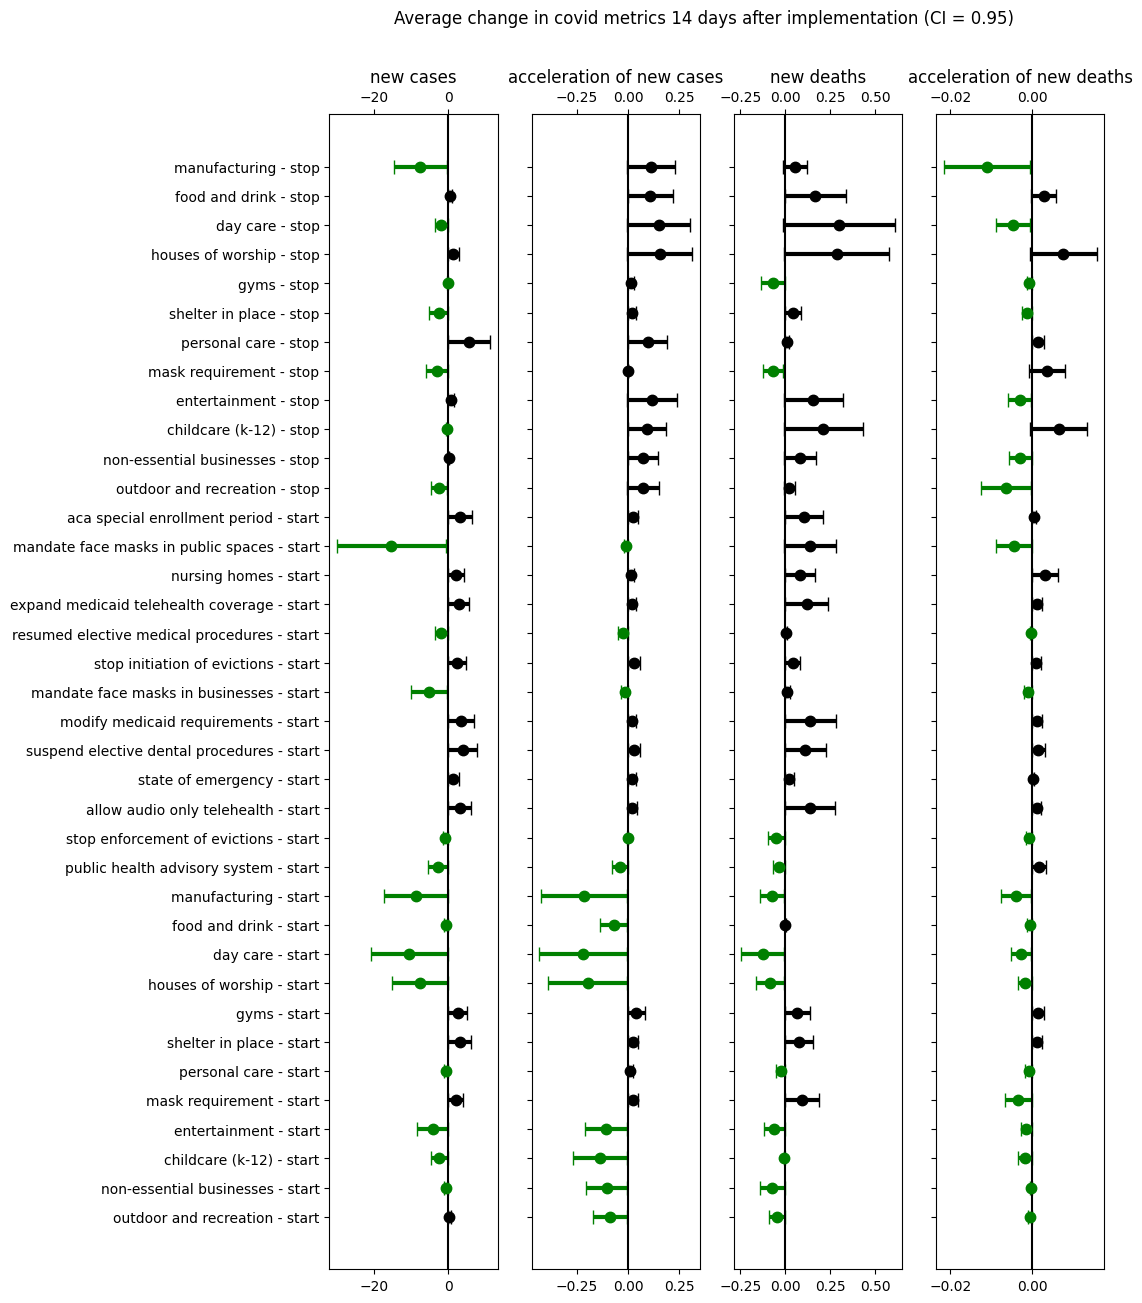

In [10]:
fig = plot_delta_stats(delta_stats,
                 save_figure=True,
                 interval="0.95",
                 filename="./figures/average_changes_in_covid_metrics_14_days_95CI.png");

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/plotting_funcs.py:444: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = delta_stats.loc[index][8]


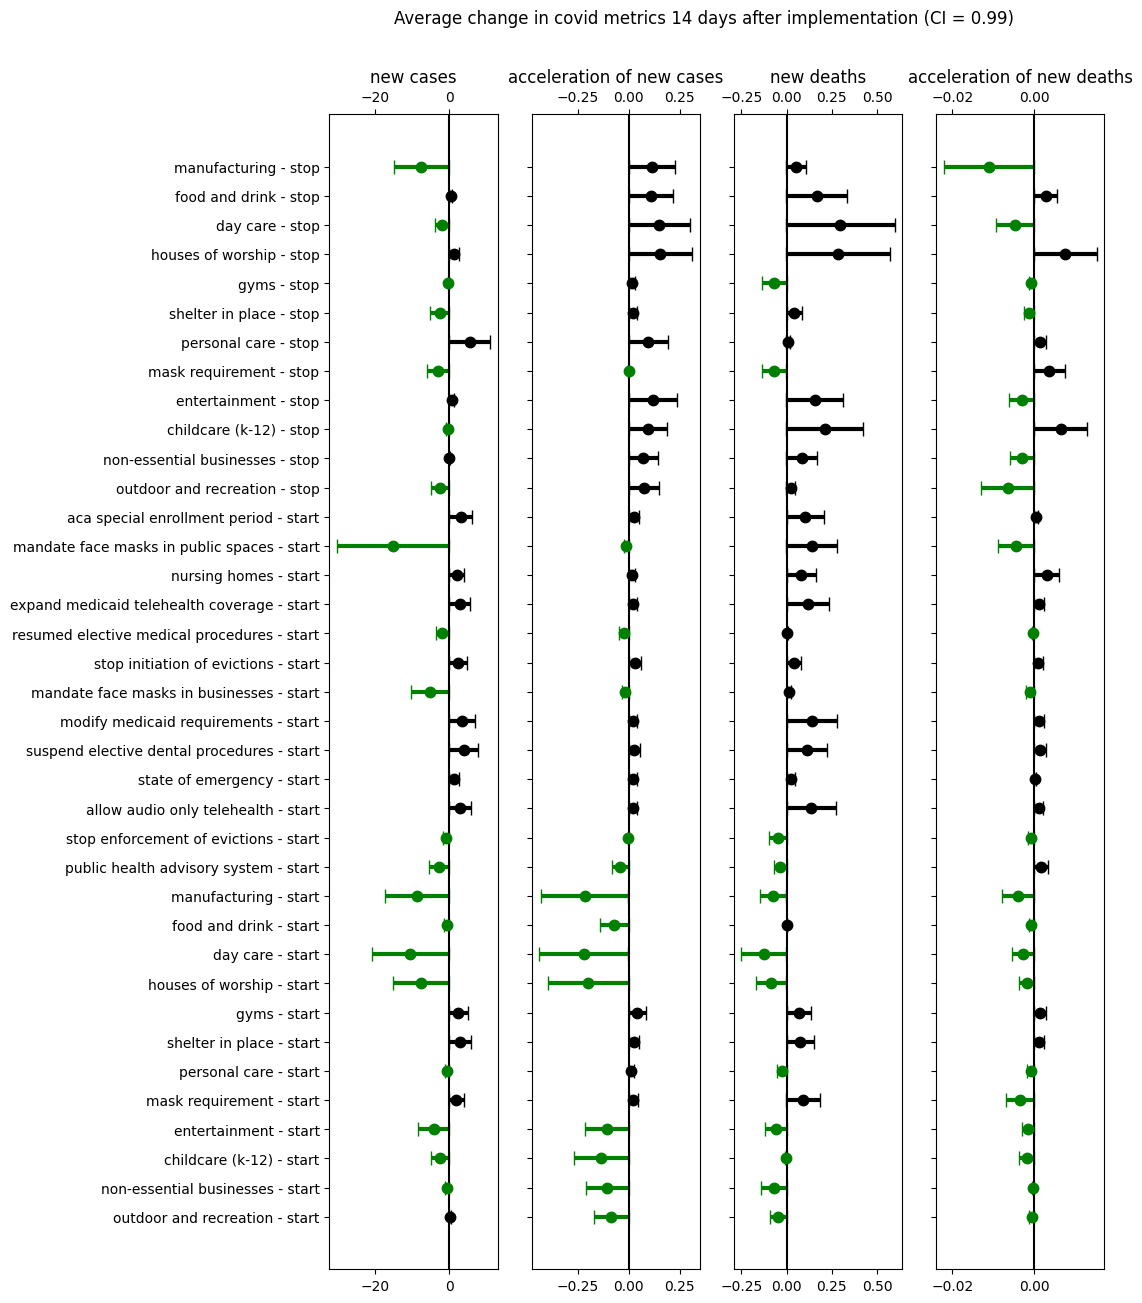

In [11]:
fig = plot_delta_stats(delta_stats,
                 save_figure=True,
                 interval="0.99",
                 filename="./figures/average_changes_in_covid_metrics_14_days_99CI.png");


After 14 days, there seems to be a signficiant change in new cases 14 days after 'aca-special enrollment period-start', 'suspend elective dental procedues - start' (same with deaths).

Even though these policies give changes that are more than one standard deviation from the mean, I am not convinced that these are actually significant results based on how many show no significance whatsoever and that these policies have relatively small sample sizes compared to the others.

How do these change when we change the measure period?

# 2. Investigate correlations from 1-30 days

In [18]:
def check_significance(delta_stats):
    """Adds a column to the delta stats dataframe determining wether the mean change in a given policy is more than 1 standard deviation above / below zero."""
    cols_of_interest = ['case',  'case_accel', 'death', 'death_accel']
    for col in cols_of_interest:
        delta_stats[f"{col}_significant"] = (np.abs(delta_stats[f"{col}_avg"]) -\
                                                np.abs(delta_stats[f"{col}_std"])) > 0
    return delta_stats
delta_stats = check_significance(delta_stats)

In [19]:
delta_stats

,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples,t_0.9,...,death_0.99_ci_range,death_0.99_low,death_0.99_high,death_accel_0.99_ci_range,death_accel_0.99_low,death_accel_0.99_high,case_significant,case_accel_significant,death_significant,death_accel_significant
outdoor and recreation - start,0.290244,-0.086085,-0.045676,-0.000613,25.967494,0.648603,0.718209,0.024530,242.0,0.125793,...,0.045097,0.090773,-0.000579,0.000594,0.001207,-0.000020,False,False,False,False
non-essential businesses - start,-0.597275,-0.104113,-0.071612,-0.000307,26.253823,0.664652,0.743605,0.025037,224.0,0.125804,...,0.070988,0.142600,-0.000623,0.000286,0.000593,-0.000021,False,False,False,False
childcare (k-12) - start,-2.417826,-0.135299,-0.005124,-0.001843,30.088935,0.795965,0.935644,0.030834,190.0,0.125829,...,0.004272,0.009396,-0.000852,0.001815,0.003659,-0.000028,False,False,False,False
entertainment - start,-4.194054,-0.106940,-0.060399,-0.001500,24.593333,0.653241,0.780471,0.026467,196.0,0.125824,...,0.059700,0.120099,-0.000700,0.001476,0.002977,-0.000024,False,False,False,False
mask requirement - start,1.950202,0.022112,0.090919,-0.003435,22.684047,0.632568,1.100998,0.031366,245.0,0.125792,...,0.091802,0.000883,0.182721,0.003410,0.006844,-0.000025,False,False,False,False
personal care - start,-0.615535,0.011690,-0.026650,-0.000892,7.856536,0.193908,0.205334,0.003367,43.0,0.126406,...,0.026255,0.052906,-0.000395,0.000885,0.001777,-0.000006,False,False,False,False
shelter in place - start,3.006102,0.024114,0.075990,0.001152,8.905098,0.187170,0.470997,0.007054,456.0,0.125731,...,0.076266,0.000277,0.152256,0.001156,0.000004,0.002309,False,False,False,False
gyms - start,2.474565,0.041132,0.066770,0.001383,3.471230,0.126404,0.237674,0.006003,49.0,0.126314,...,0.067198,0.000428,0.133968,0.001394,0.000011,0.002777,False,False,False,False
houses of worship - start,-7.647302,-0.197443,-0.084553,-0.001915,31.114065,0.823650,0.990351,0.036284,121.0,0.125925,...,0.083423,0.167976,-0.001131,0.001873,0.003788,-0.000041,False,False,False,False
day care - start,-10.525132,-0.220070,-0.126102,-0.002751,33.548734,0.929624,1.137298,0.038878,87.0,0.126029,...,0.124569,0.250672,-0.001533,0.002699,0.005450,-0.000052,False,False,False,False


In [14]:
# def count_significant(delta_stats):
#     """Get the 'significant' policies for cases, case accel, death, and death accel"""
#     cols_of_interest = ['case',  'case_accel', 'death', 'death_accel']
#     res = {col: [] for col in cols_of_interest}
#     for policy in delta_stats.index:
#         for col in cols_of_interest:
#             if delta_stats.loc[policy, f"{col}_significant"]:
#                 res[col].append(policy)
#     return res
# 
# count_significant(delta_stats)

Now, Run the analysis on 1 through 30 days 

In [15]:
# results = dict()
# 
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore") # lots of numpy warnings for mean of empty slice
#     for measure_period in tqdm(range(1, 31)):
#         correlated_df, state_cases_dict = calculate_deltas(
#             case_df = case_data,
#             policy_df = policy_data,
#             measure_period = measure_period,
#         )
#         delta_stats = calc_delta_stats(correlated_df,
#                                        measure_period=measure_period,
#                                        min_samples=3)
#         delta_stats = check_significance(delta_stats)
#         results[measure_period] = count_significant(delta_stats)

In [16]:
# cols_of_interest = ['case',  'case_accel', 'death', 'death_accel']
# results_counts = {num: {
#     col: len(results[num][col]) for col in cols_of_interest
# } for num in results.keys()}

In [17]:
# results_counts

They all seem to be pretty evenly spread. It looks like this analysis of the differences may not be a good way to model the problem. 



# items for write-up:

- positive effects only - very suspicious
- data is not normally distributed. (see figure)
- fix this to one confidence interval
- discuss limitations:
    - policies are concurrent
    - doesn't account for variation in policy enforcement / compliance
 
- idea: mixture of gaussians to find multiple populations